# Анализ внешних данных с частотой в 1 день

## Оглавление

### Оглавление

1. **Импорт необходимых библиотек**
   - Подключение библиотек для анализа данных, работы с датами и API MOEX.

2. **Вспомогательные функции**

3. **Получение данных**

4. **Объединение данных**
   - Слияние данных по фьючерсам, ключевой ставке и валютным курсам в единый DataFrame.

5. **EDA**
   - Проверка пропущенных значений и их обработка.
   - Базовая статистика.
   - Визуализация временных рядов.
   - Тестирование временных рядов на стационарность.
   - Построение корреляционной матрицы курсов валют.

6. **Обработка временных рядов**
   - Преобразование данных для получения стационарных временных рядов.
   - ADF тест для всех временных рядов.
   - Построение автокорреляционных графиков (ACF и PACF).

7. **Скользящие окна**
   - Расчет скользящего изменения валютных курсов и цен на фьючерсы с использованием формулы сложного процента.
   - Визуализация скользящих изменений для различных временных окон (30 и 365 дней).

## 1. Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import timedelta, date, datetime
import apimoex
import requests
import time
from statsmodels.tsa.stattools import adfuller, acf, pacf

## 2. Вспомогательные функции

- `BR_code` - преобразует дату в название фьючерса на нефть марки `Brent` (с тем же месяцем и годом исполнения)

In [2]:
def BR_code(on_date):
    current_year = date.today().year
    
    month_codes = 'FGHJKMNQUVXZ'
    month = on_date.month
    year = on_date.year
    year_code = str(year)[-1]
    month_code = month_codes[month-1]
    if year <= current_year - 6:
        return f"BR{month_code}{year_code}_{year}"
    else:
        return f"BR{month_code}{year_code}"

- `BR_decode` - возвращает дату (месяц и год) исполнения фьючерса из его названия

In [3]:
def BR_decode(code):
    month_codes = 'FGHJKMNQUVXZ'
    month_code = code[2]
    year_code = code[3]
    month = month_codes.index(month_code) + 1
    
    if "_" in code:
        year = int(code.split('_')[1])
    else:
        current_year = date.today().year
        current_decade = current_year // 10 * 10
        last_digit_of_current_year = current_year % 10
        year_last_digit = int(year_code)
        
        if year_last_digit > last_digit_of_current_year:
            year = current_decade - 10 + year_last_digit
        else:
            year = current_decade + year_last_digit
    return date(year, month, 1)

- `generate_BR_list` - создает список названий всех фьючерсов на нефть марки `Brent`, даты исполнения которых выпадают на указанный диапазон лет

In [4]:
def generate_BR_list(start_year, end_year):
    tickers = []
    for year in range(start_year, end_year + 1):
        for month in range(1, 13):
            ticker_date = date(year, month, 1)
            ticker = BR_code(ticker_date)
            tickers.append(ticker)
    return tickers

- `adf_test`: Проводит ADF тест на стационарность временного ряда.

In [5]:
def adf_test(series: pd.Series) -> float:
    result = adfuller(series.dropna(), autolag='AIC')
    return round(result[1], 3)

- `plot_acf_pacf` - выводит графики автокорреляции (ACF) и частичной автокорреляции (PACF)

In [6]:
def plot_acf_pacf(data: pd.DataFrame|pd.Series, lags=40):
    if isinstance(data, pd.Series):
        data = data.to_frame()
    fig, axes = plt.subplots(len(data.columns), 2, figsize=(15, 2*len(data.columns)))
    if axes.ndim == 1:
        axes = axes.reshape(1, 2)
    for idx, ticker in enumerate(data.columns):
        series = data[ticker].dropna()
        
        # ACF
        acf_values = acf(series, nlags=lags)
        acf_values[0] = np.nan
        axes[idx, 0].stem(range(len(acf_values)), acf_values)
        axes[idx, 0].set_title(f'ACF - {ticker}')
        axes[idx, 0].axhline(y=0, linestyle='-', color='gray')
        axes[idx, 0].axhline(y=-1.96/np.sqrt(len(series)), linestyle='--', color='red', alpha=0.4)
        axes[idx, 0].axhline(y=1.96/np.sqrt(len(series)), linestyle='--', color='red', alpha=0.4)
        
        # PACF
        pacf_values = pacf(series, nlags=lags)
        pacf_values[0] = np.nan
        axes[idx, 1].stem(range(len(pacf_values)), pacf_values)
        axes[idx, 1].set_title(f'PACF - {ticker}')
        axes[idx, 1].axhline(y=0, linestyle='-', color='gray')
        axes[idx, 1].axhline(y=-1.96/np.sqrt(len(series)), linestyle='--', color='red', alpha=0.4)
        axes[idx, 1].axhline(y=1.96/np.sqrt(len(series)), linestyle='--', color='red', alpha=0.4)

    plt.tight_layout()
    plt.show()

## 3. Получение данных

### CB - Key Rate

In [7]:
rate = pd.read_csv('data/rate.csv', header=None)
rate.columns = ['date', 'key rate']

rate['date'] = rate['date'].str.extract(r'(\d{4}-\d{2}-\d{2})')[0]
rate['date'] = pd.to_datetime(rate['date'], format='%Y-%m-%d')
rate = rate.set_index('date').sort_index()

# Заполняем единственное пропущенное значение
# rate.loc[:, 'key rate'] = rate.loc[:, 'key rate'].ffill()

rate.columns = pd.MultiIndex.from_product([['CB'], rate.columns])

### CB - Exchange rates

In [8]:
curr = pd.read_csv('data/currencies.csv', index_col=0)
curr.index = curr.index.str.extract(r'(\d{4}-\d{2}-\d{2})')[0]
curr.index.name = 'date'
curr.index = pd.to_datetime(curr.index, format='%Y-%m-%d')
curr.columns = pd.MultiIndex.from_product([['CB'], curr.columns])

### MOEX - Brent futures

In [9]:
start_year = 2008 # Первый доступный тикер: BRX8_2008
end_year = date.today().year + 1
tickers = generate_BR_list(start_year, end_year)

# TODO: лучше тоже обернуть в классы в дальнейшем

In [10]:
# Takes some time (~2m)

# df_futures = pd.DataFrame()
# with requests.Session() as session:
#     for ticker in tickers:
#         future = apimoex.get_board_history(
#             session,
#             board='RFUD',
#             security=ticker,
#             market='forts',
#             engine='futures'
#         )
#         temp_df = pd.DataFrame(future)
#         if df_futures.empty and not temp_df.empty:
#             temp_df['ID'] = ticker
#             df_futures = temp_df
#             continue
#         if not temp_df.empty:
#             temp_df['ID'] = ticker
#             df_futures = pd.concat([df_futures, temp_df], ignore_index=True)
#         time.sleep(0.5)
# df_futures['Exp_date'] = pd.to_datetime(df_futures['ID'].apply(BR_decode))
# df_futures['TRADEDATE'] = pd.to_datetime(df_futures['TRADEDATE'])
# df_futures['delta_days'] = (df_futures['Exp_date'] - df_futures['TRADEDATE']).dt.days
# df_futures.to_pickle('data/df_futures.pkl')

df_futures: pd.DataFrame = pd.read_pickle('data/df_futures.pkl')

In [11]:
df_filt = df_futures[
    (0 < df_futures['delta_days']) &
    (df_futures['Exp_date'].dt.month - df_futures['TRADEDATE'].dt.month <= 1) &
    (df_futures['Exp_date'].dt.year == df_futures['TRADEDATE'].dt.year)
    ].dropna()

# TODO: рассмотреть другие варианты комбинации цен на фьючерсы: может, rolling window
# На текущем этапе в качестве цены берется стоимость фьючерса с ближайшей (к дате торгов) датой исполнения

df_filt.set_index('TRADEDATE', inplace=True)
df_filt.drop(['BOARDID', 'delta_days'], axis=1, inplace=True)
df_filt.columns = pd.MultiIndex.from_product([['Brent futures'], df_filt.columns])

## 4. Объединение данных

In [12]:
df_merged = df_filt.merge(rate, how='outer', left_index=True, right_index=True).sort_index()
df_merged = df_merged.merge(curr, how='outer', left_index=True, right_index=True).sort_index()

## 5. EDA

### Проверка пропущенных значений

Определение первой даты с полными данными

In [13]:
fvi = df_merged.apply(lambda x: x.first_valid_index()).max()
fvi.strftime(f'%d.%m.%Y')

'08.10.2008'

Смотрим на пропуски

In [14]:
df_merged.isna().sum()

Brent futures  CLOSE       2993
               VOLUME      2993
               VALUE       2993
               ID          2993
               Exp_date    2993
CB             key rate       2
               Доллар         0
               Евро           0
               Юань           0
dtype: int64

Всему виной фьючерсы...

### Базовая статистика

In [15]:
df_merged.describe(include='number').round(2)

Brent futures                                  CB                    \
              CLOSE       VOLUME         VALUE key rate   Доллар     Евро   
count       3691.00      3691.00  3.691000e+03  6682.00  6684.00  6684.00   
mean          77.61    817871.98  3.245414e+10     9.28    51.65    61.06   
std           23.93   1117526.38  4.178831e+10     3.01    21.84    21.24   
min           19.16        24.00  3.235427e+05     4.25    23.13    33.72   
25%           58.56     28383.00  7.471794e+08     7.50    30.58    40.53   
50%           76.11    180121.00  1.148074e+10     8.25    56.98    61.85   
75%           99.54   1520473.50  5.795481e+10    11.00    67.52    76.05   
max          126.00  12493298.00  3.469739e+11    21.00   120.38   132.96   

                
          Юань  
count  6684.00  
mean      7.68  
std       3.17  
min       3.28  
25%       4.62  
50%       8.58  
75%      10.14  
max      19.04

### Визуализация временных рядов

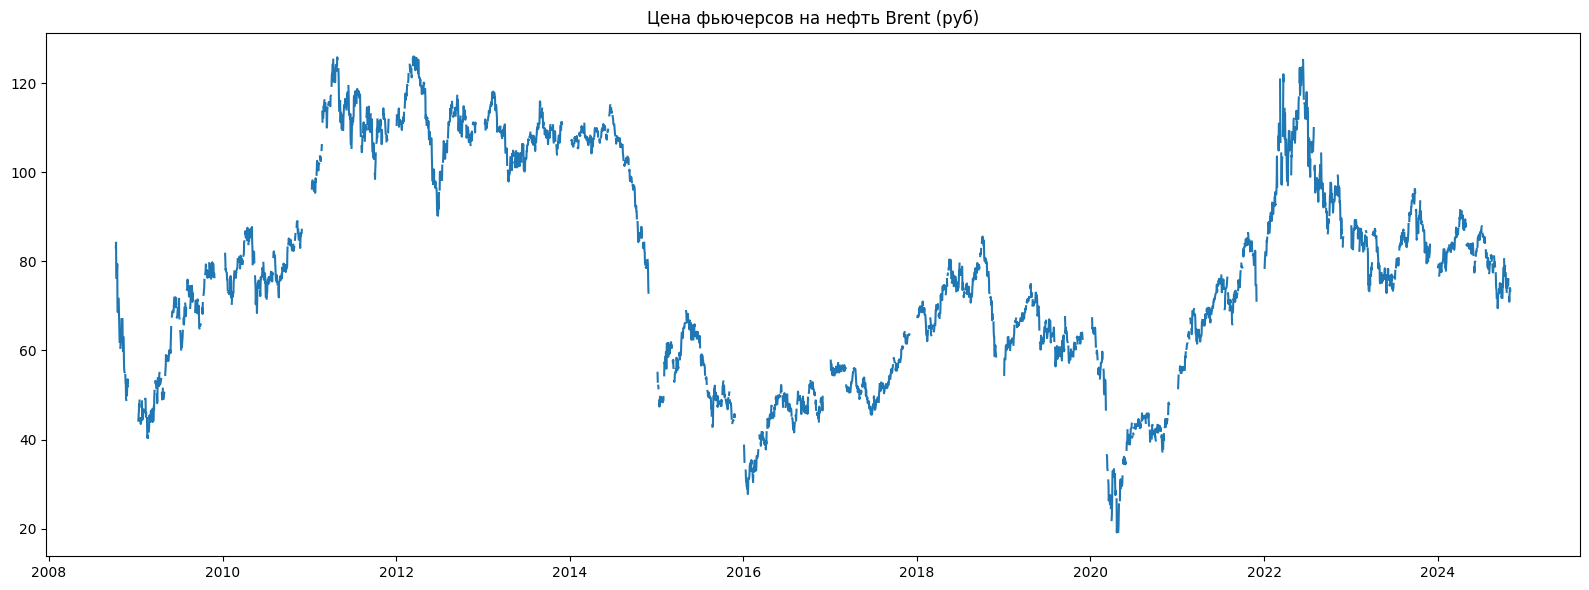

In [16]:
plt.figure(figsize=(16,6))
plt.plot(df_merged['Brent futures']['CLOSE'])
plt.title('Цена фьючерсов на нефть Brent (руб)')
plt.tight_layout()

In [17]:
df_merged.loc[:,'CB'].drop('key rate', axis=1)

,Доллар,Евро,Юань
2006-07-17,26.9277,34.0151,3.36689
2006-07-18,26.9277,34.0151,3.36689
2006-07-19,27.0194,33.8661,3.37489
2006-07-20,27.0554,33.8247,3.38023
2006-07-21,26.9674,33.9789,3.37261
...,...,...,...
2024-10-29,97.2300,105.2229,13.61030
2024-10-30,97.3261,105.4375,13.59540
2024-10-31,97.0530,105.2211,13.58760
2024-11-01,97.0226,105.5231,13.60680


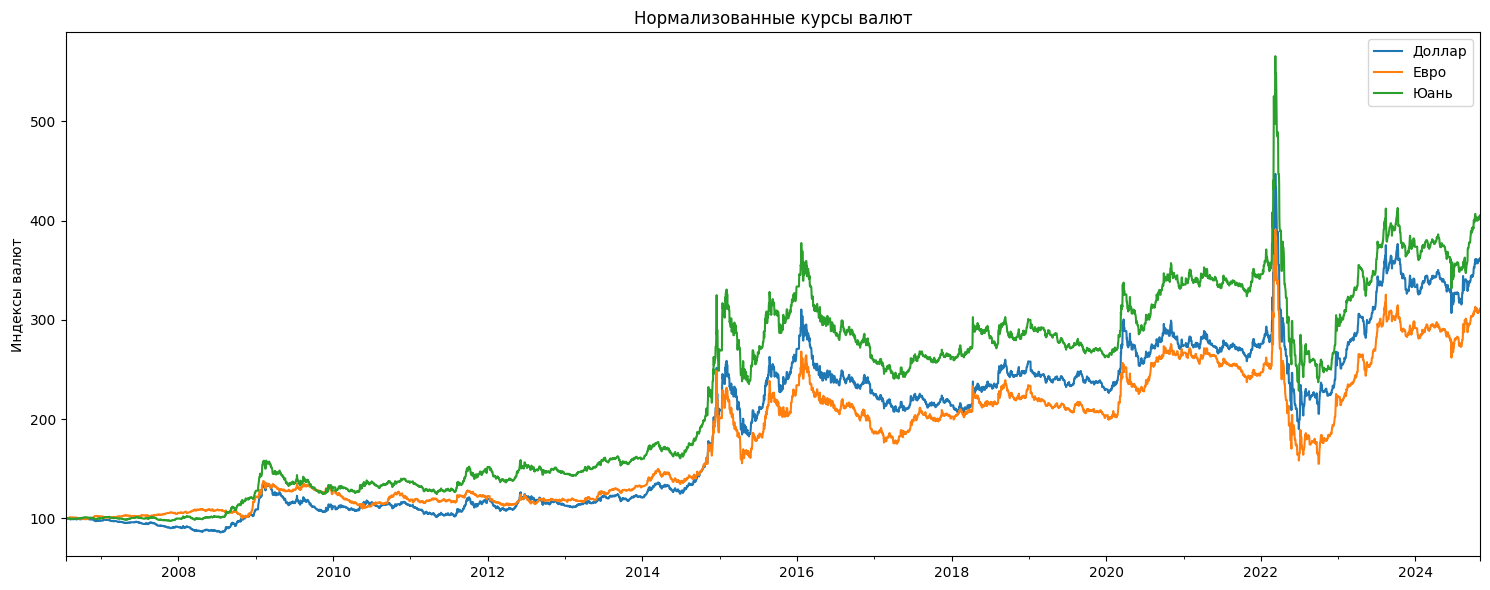

In [18]:
normalized =    df_merged.loc[:,'CB'].drop('key rate', axis=1) /\
                df_merged.loc[:,'CB'].drop('key rate', axis=1).iloc[0, :] * 100
normalized.plot(figsize=(15, 6))
plt.title('Нормализованные курсы валют')
plt.ylabel('Индексы валют')
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
df_merged.loc[:,'CB'].drop('key rate', axis=1).describe()

,Доллар,Евро,Юань
count,6684.000000,6684.000000,6684.000000
mean,51.652313,61.058321,7.676181
std,21.839783,21.238816,3.170440
min,23.125500,33.724700,3.279440
25%,30.577800,40.527025,4.619330
50%,56.983800,61.852750,8.582820
75%,67.517500,76.051900,10.142500
max,120.378500,132.958100,19.041500


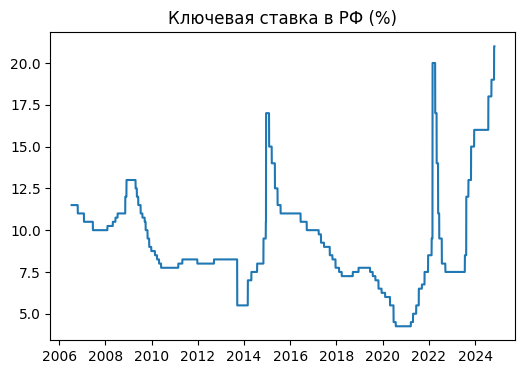

In [20]:
plt.figure(figsize=(6, 4))
plt.plot(df_merged.loc[:,'CB']['key rate'])
plt.title('Ключевая ставка в РФ (%)')
plt.show()

In [21]:
df_merged.loc[:, 'CB']['key rate'].describe().to_frame()

,key rate
count,6682.000000
mean,9.279894
std,3.008864
min,4.250000
25%,7.500000
50%,8.250000
75%,11.000000
max,21.000000


### Построение корреляционной матрицы валют

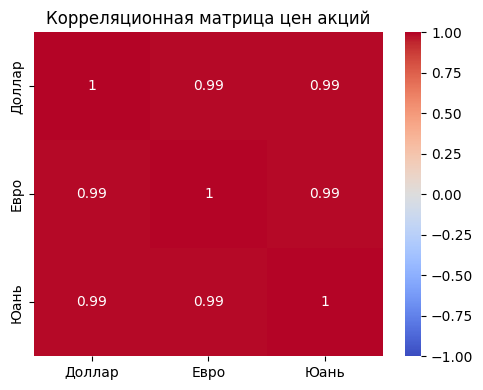

In [22]:
plt.figure(figsize=(5, 4))
correlation_matrix = df_merged.loc[:,'CB'].drop('key rate', axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Корреляционная матрица цен акций")
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()

## 6. Обработка временных рядов

### Перевод временных рядов в стационарные

<Axes: >

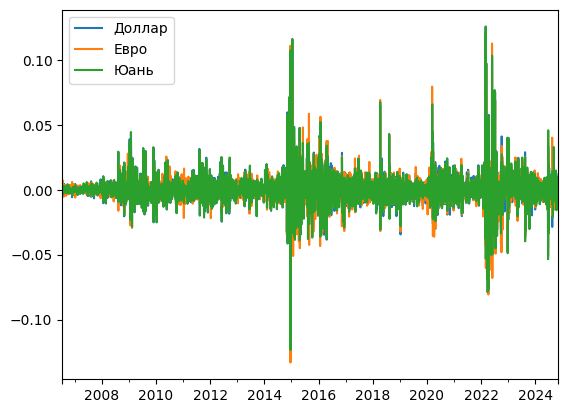

In [23]:
df_XR_stat = df_merged.loc[:,'CB'].drop('key rate', axis=1).pct_change()
df_XR_stat.plot()

In [24]:
df_XR_stat.apply(adf_test)

Доллар    0.0
Евро      0.0
Юань      0.0
dtype: float64

<Axes: >

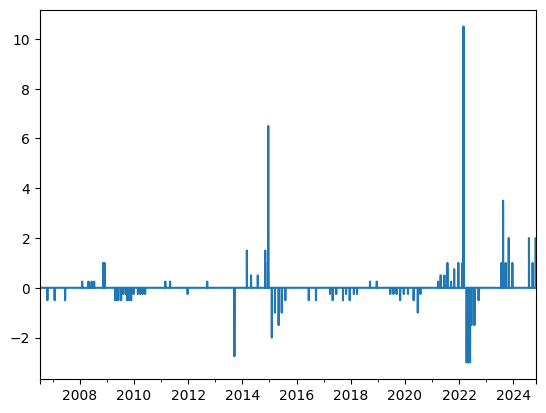

In [25]:
df_KR_stat = df_merged.loc[:,'CB']['key rate'].diff()
df_KR_stat.plot()

In [26]:
df_KR_stat.to_frame().apply(adf_test)

key rate    0.0
dtype: float64

<Axes: >

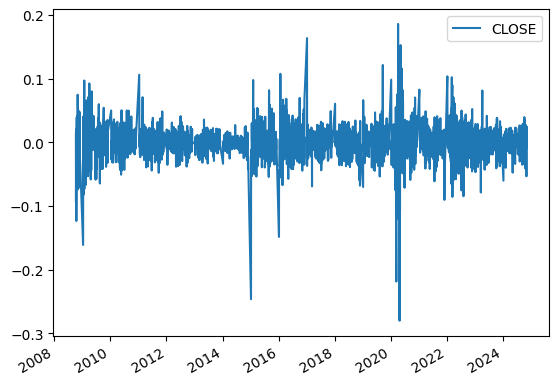

In [27]:
df_brent_stat = df_merged['Brent futures']['CLOSE'].dropna().pct_change().to_frame()
df_brent_stat.plot()

In [28]:
df_brent_stat.describe()

,CLOSE
count,3690.000000
mean,0.000241
std,0.023247
min,-0.279970
25%,-0.009667
50%,0.000887
75%,0.010787
max,0.185600


### Анализ автокорреляции (ACF) и частичной автокорреляции (PACF)

#### Курсы валют

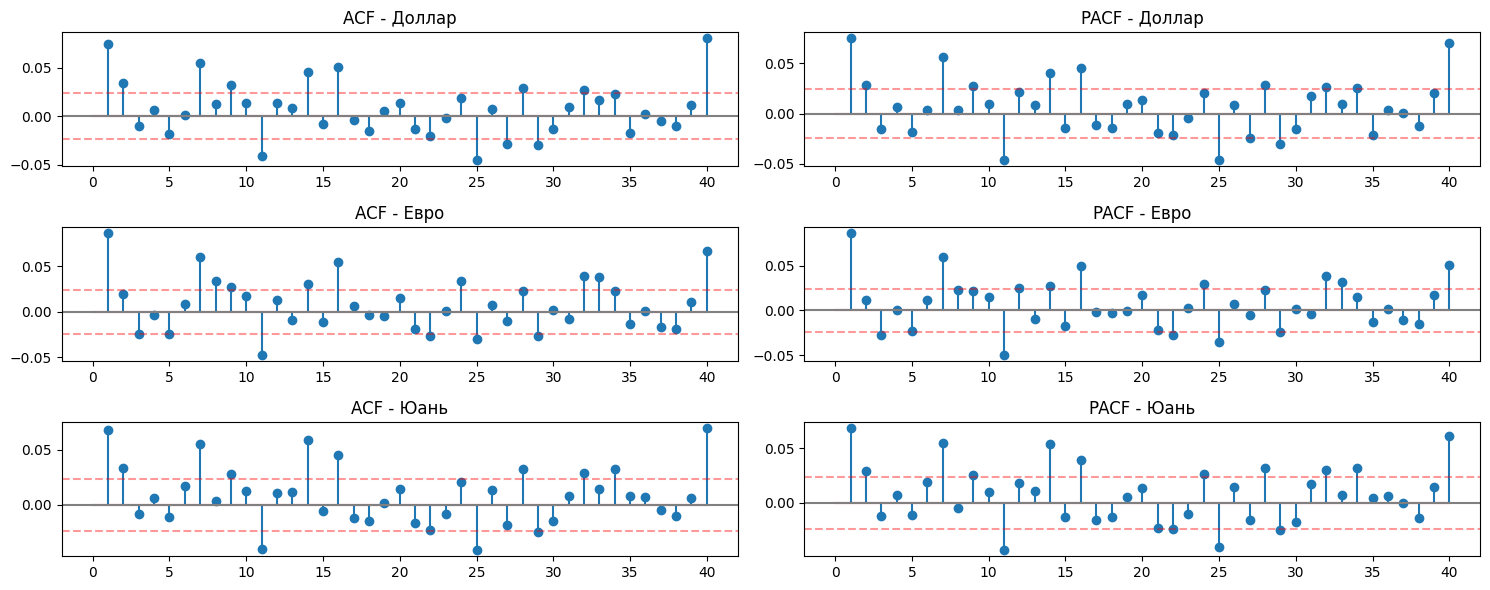

In [29]:
plot_acf_pacf(df_XR_stat)

#### Фьючерсы на Brent

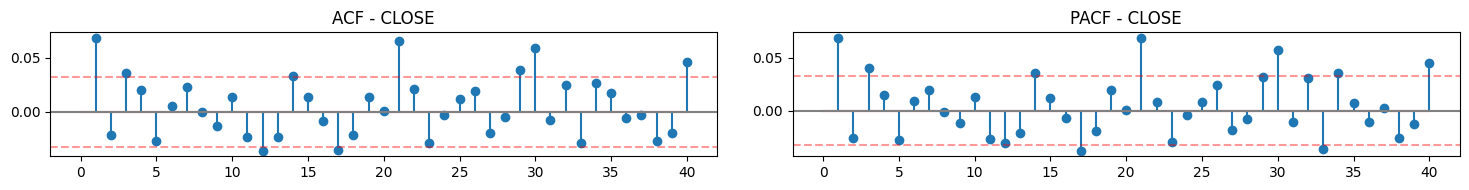

In [30]:
plot_acf_pacf(df_brent_stat)

## 7. Скользящие окна

Используем формулу сложного $\%$, аналогично доходности, потому что
если курс упал на $10\%$ и потом вырос на $10\%$, то его изменение за этот период составит:
$0.9 \cdot 1.1 = 0.99$, т.е. $-1\%$, а не $0$

#### Курсы валют

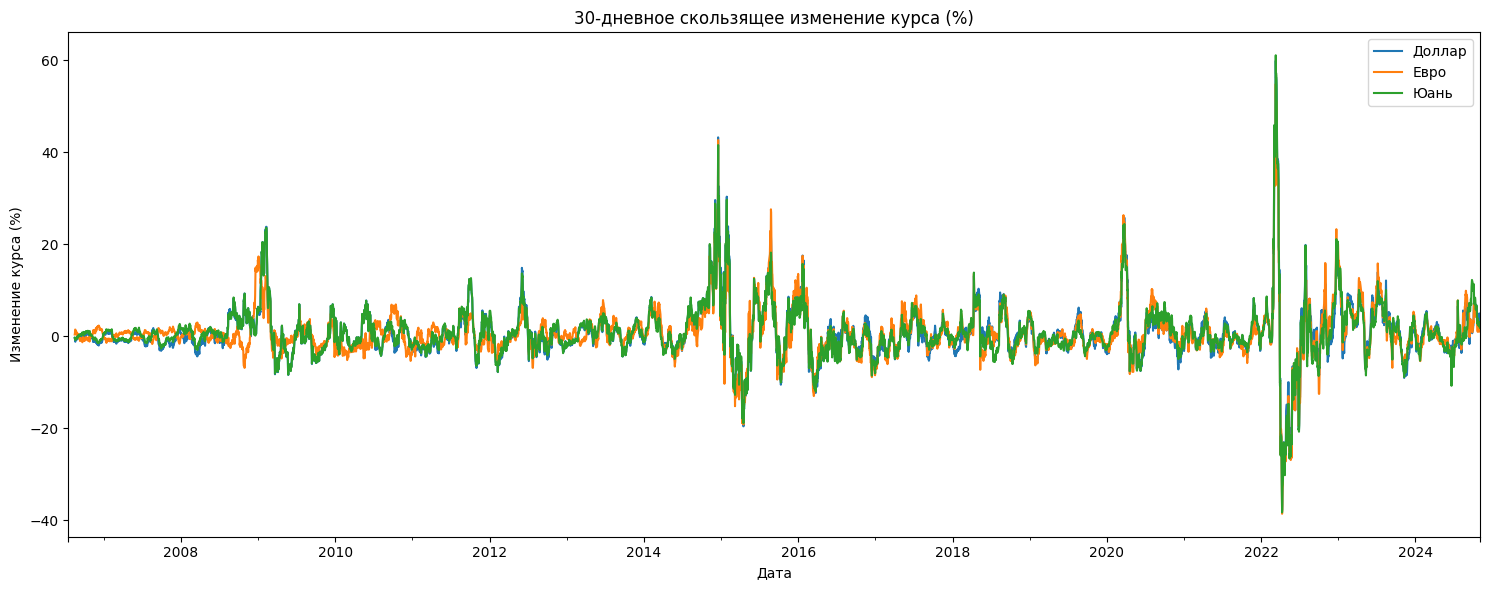

In [31]:
vol_window = 30
rolling_vol = df_XR_stat.rolling(window=vol_window).apply(lambda x: (1 + x).prod() - 1) * 100
rolling_vol.plot(figsize=(15, 6))
plt.title(f'{vol_window}-дневное скользящее изменение курса (%)')
plt.xlabel('Дата')
plt.ylabel('Изменение курса (%)')
plt.legend()
plt.tight_layout()
plt.show()

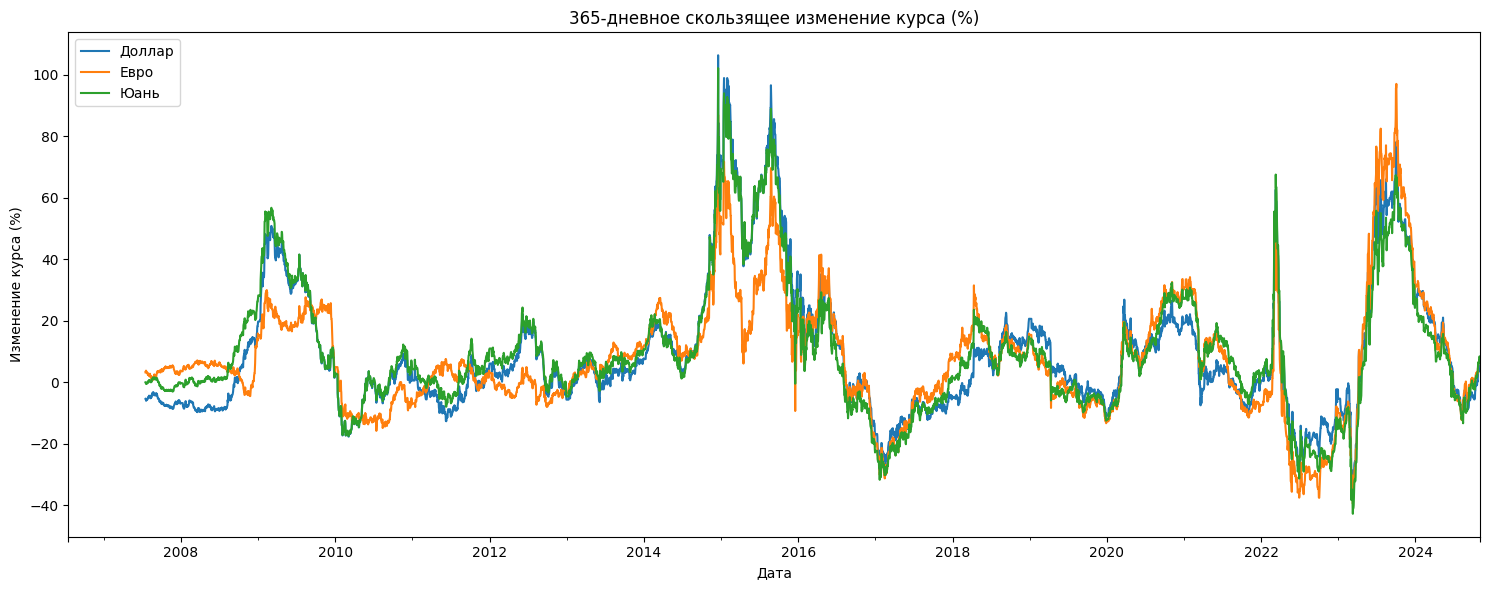

In [32]:
vol_window = 365
rolling_vol = df_XR_stat.rolling(window=vol_window).apply(lambda x: (1 + x).prod() - 1) * 100
rolling_vol.plot(figsize=(15, 6))
plt.title(f'{vol_window}-дневное скользящее изменение курса (%)')
plt.xlabel('Дата')
plt.ylabel('Изменение курса (%)')
plt.legend()
plt.tight_layout()
plt.show()

#### Фьючерсы на Brent

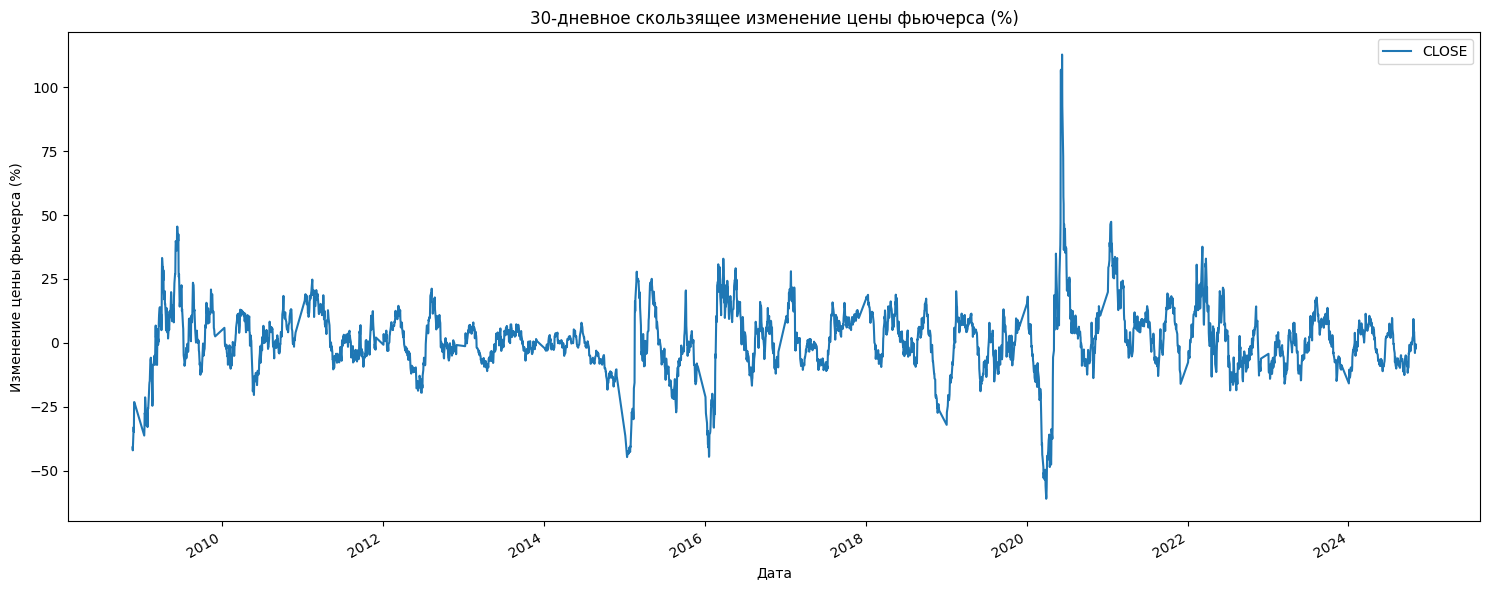

In [33]:
vol_window = 30
rolling_vol = df_brent_stat.rolling(window=vol_window).apply(lambda x: (1 + x).prod() - 1) * 100
rolling_vol.plot(figsize=(15, 6))
plt.title(f'{vol_window}-дневное скользящее изменение цены фьючерса (%)')
plt.xlabel('Дата')
plt.ylabel('Изменение цены фьючерса (%)')
plt.legend()
plt.tight_layout()
plt.show()

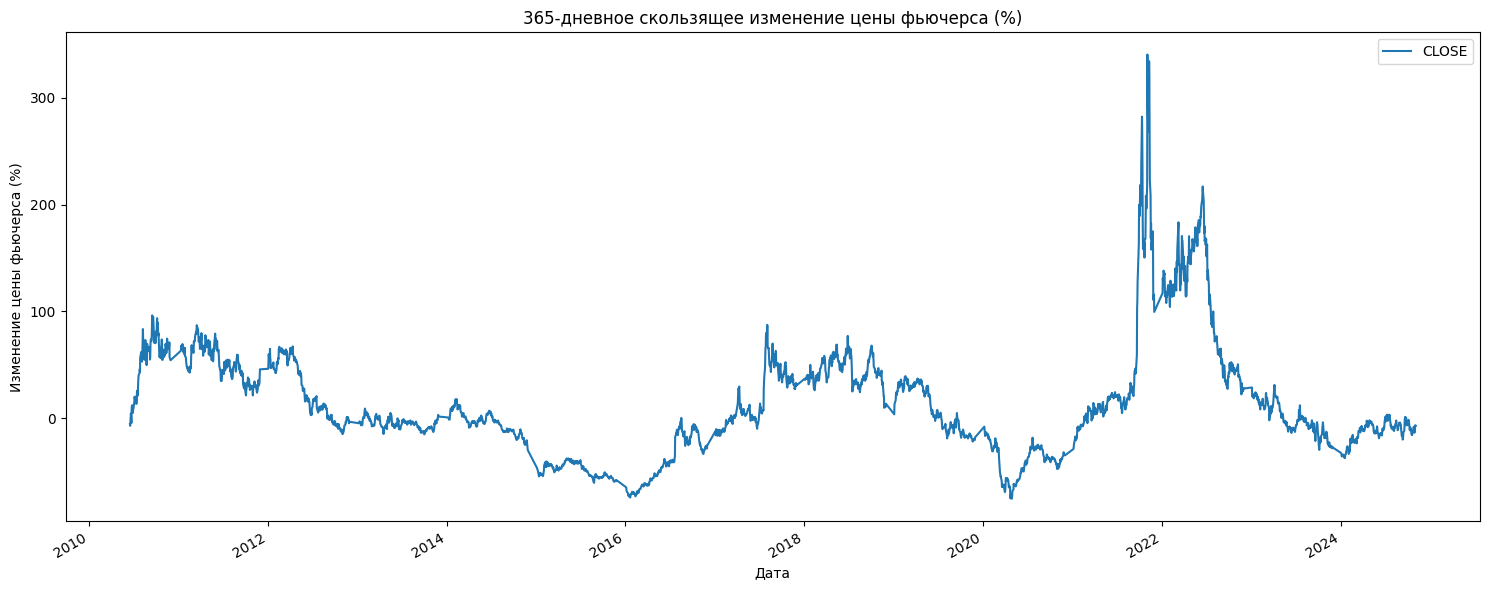

In [34]:
vol_window = 365
rolling_vol = df_brent_stat.rolling(window=vol_window).apply(lambda x: (1 + x).prod() - 1) * 100
rolling_vol.plot(figsize=(15, 6))
plt.title(f'{vol_window}-дневное скользящее изменение цены фьючерса (%)')
plt.xlabel('Дата')
plt.ylabel('Изменение цены фьючерса (%)')
plt.legend()
plt.tight_layout()
plt.show()